**Run all the cells below to make sure everything is working and ready to go. All cells should run without error.**

## Imports

In [7]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Camera Calibration

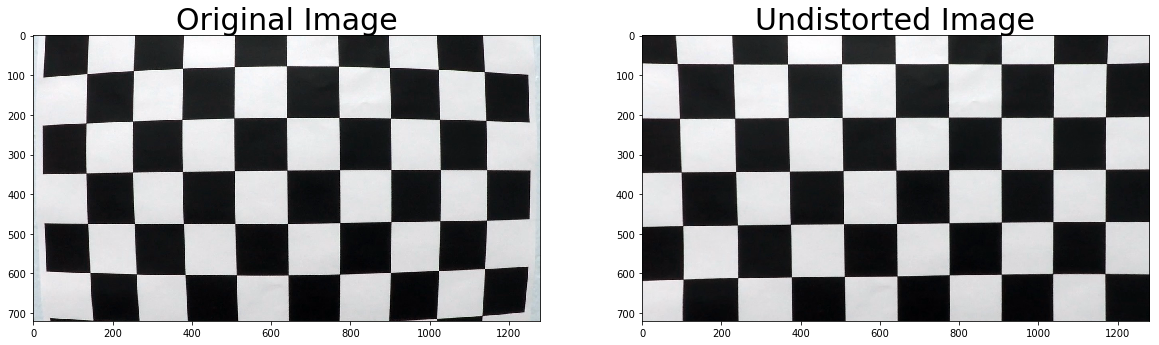

In [8]:
# Make a list of calibration images
input_dir = "camera_cal/"
images = os.listdir(input_dir)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)


for image_to_read in images:
    image_in = mpimg.imread(input_dir+image_to_read)
    gray = cv2.cvtColor(image_in,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if(ret == True):
        imgpoints.append(corners)
        objpoints.append(objp)
    
        # Plot images for debug reasons
        #img_draw = cv2.drawChessboardCorners(image_in, (9,6), corners, ret)
        #plt.figure()
        #plt.imshow(img_draw)
        
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save calibration to pickle
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calibration.p", "wb" ) )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

# Save pickle
dist_pickle = pickle.load( open( "camera_calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

## Threshold functions

In [9]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    gray = hls[:,:,2] # V 
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
   # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    gray = hls[:,:,2] # V 
    
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh=(0, 255), sobel_kernel=3):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    gray = hsv[:,:,2] # V 
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


def get_v_channel_binary(img, thresh=(0, 255)):
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    
    # Threshold color channel
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= thresh[0]) & (v_channel <= thresh[1])] = 1
    
    return v_binary


def get_s_channel_binary(img, thresh=(0, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return s_binary



## Lane Detector Class

In [10]:
class LaneDetector():
    def __init__(self, 
                 my_debug_write = False, 
                 my_debug_plot = False,                  
                 my_image_output_folder='test_images_output/',
                 my_image_filename_post='',
                 my_smooth_factor=5,
                 my_ym_per_pix=30/720,
                 my_xm_per_pix=3.7/700           
                ):
        
        self.debug_write = my_debug_write;  
        self.debug_plot = my_debug_plot; 
        self.image_output_folder = my_image_output_folder;
        self.image_filename_post = my_image_filename_post; # post_filename for image_output
        self.smooth_factor = my_smooth_factor

        self.ym_per_pix = my_ym_per_pix # meters per pixel in y dimension
        self.xm_per_pix = my_xm_per_pix # meters per pixel in x dimension

        self.recent_left_fits = []
        self.recent_right_fits = []
            
        self.left_fits = []
        self.right_fits = []
        
        self.recent_detected_left = False;
        self.recent_detected_right = False;
        
    def my_debug_out(self, img, shortname, is_gray=False):
        
        if (self.debug_plot): # Plot Image on screen
            plt.figure()
            if(is_gray == True):
                plt.imshow(img, cmap='gray')
            else:
                plt.imshow(img)
            plt.title(shortname, fontsize=25)
            
        # Write image to output_folder
        if (self.debug_write):
            if (is_gray == False):
                cv2.imwrite(self.image_output_folder  + shortname + self.image_filename_post + '.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            else:
                cv2.imwrite(self.image_output_folder  + shortname + self.image_filename_post + '.jpg', img)
        

    def print_curvature_on_image(self, image, left_curverad, right_curverad, delocation):
        text_left = str('left: %.3f m'%(left_curverad))
        text_right = str('right: %.3f m'%(right_curverad))

        font = cv2.FONT_HERSHEY_SIMPLEX
        image = cv2.putText(image, text_left, (40,60), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
        image = cv2.putText(image, text_right, (40,120), font, 1.5, (255,255,255), 2, cv2.LINE_AA)

        # Print delocation from center

        text_center = str('delocation: %.3f m'%(delocation))
        result = cv2.putText(image, text_center, (40,180), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
        
        return result
    
    def print_histogram(self, histogram, title):
        if (self.debug_plot): # Plot Image on screen
            plt.figure()
            plt.plot(histogram)
            plt.title('Histogram', fontsize=25)
    
    
    def process_image(self, image_in):

        #################################################################
        # STEP 1: Correct distrotion
        image = image_in
        self.my_debug_out(image_in, '01_image_in', False)

        undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
        self.my_debug_out(undistorted_image, '02_undistorted_image', False)

        #################################################################
        # STEP 2: Use color transforms, gradients, etc., to create a thresholded binary image.
        image = undistorted_image

        # Apply each of the thresholding functions
        gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(12, 255))
        grady = abs_sobel_thresh(image, orient='y', sobel_kernel=15, thresh=(25, 255))
        mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 150))
        dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
        s_binary = get_s_channel_binary(image, thresh=(100, 255))
        v_binary = get_v_channel_binary(image, thresh=(50, 255))

        # Combine single binary outputs
        combined = np.zeros_like(undistorted_image[:,:,0])
        combined[  ((s_binary == 1) & (v_binary == 1)) | ((gradx == 1) & (grady == 1))]  = 1

        self.my_debug_out(combined*255, '03_combined', True)

        #################################################################
        # STEP 3: Black out area outside ROI
        image = undistorted_image
        image_binary = combined

        imshape = image.shape;
        vertices = np.array([[(imshape[1]*0.05/10,imshape[0]),
                              (imshape[1]*4.6/10, imshape[0]*5.5/10),
                              (imshape[1]*5.4/10, imshape[0]*5.5/10), 
                              (imshape[1]*9.95/10,imshape[0])]], dtype=np.int32)

        intarray = vertices.astype(np.int32).reshape((-1,1,2))
        plot_poly_roi = cv2.polylines(image.copy() ,[intarray], 1 ,(255,255,255),  thickness=10)

        self.my_debug_out(plot_poly_roi, '04_plot_poly_roi', False)

        mask = np.zeros_like(image_binary)   
        cv2.fillPoly(mask, vertices, 1)
        image_roi_binary = cv2.bitwise_and(image_binary, mask)

        self.my_debug_out(image_roi_binary*255, '05_image_roi_binary', True)

        #################################################################
        # STEP 4: Perspective transform
        image = undistorted_image
        image_binary = image_roi_binary

        img_size = (image.shape[1], image.shape[0])
        
        src = np.float32([[190, 720],[595, 450],[690, 450],[1120, 720]]);
        dst = np.float32([[300, 720],[300, 0],[980, 0],[980, 720]]);

        intarray = src.astype(np.int32).reshape((-1,1,2))
        image_roi_poly1 = cv2.polylines(image.copy() ,[intarray], 1 ,(255,50,50),  thickness=10)
        self.my_debug_out(image_roi_poly1, '06_image_roi_poly1', False)

        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)

        plot_warped_color = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
        self.my_debug_out(plot_warped_color, '07_plot_warped_color', False)

        warped_binary = cv2.warpPerspective(image_binary, M, img_size)
        self.my_debug_out(warped_binary*255, '08_warped_binary', True)


        #################################################################
        # STEP 5: Find Lane Lines
        binary_warped = warped_binary

        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        self.print_histogram(histogram, 'histogram')
        midpoint = np.int(histogram.shape[0]/2)
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
        if (self.recent_detected_left == True): 
            leftx_base = np.int(self.recent_left_fits[-1][0] * img_size[1] ** 2 + self.recent_left_fits[-1][1] * img_size[1] + self.recent_left_fits[-1][2])
        else:
            leftx_base = np.argmax(histogram[:midpoint])
            
        if (self.recent_detected_right == True): 
            rightx_base = np.int(self.recent_right_fits[-1][0] * img_size[1] ** 2 + self.recent_right_fits[-1][1] * img_size[1] + self.recent_right_fits[-1][2])
        else:
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 120
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        
        old_setting_left = False
        old_setting_right = False
        skip_frame = False
        
        if ( len(self.recent_left_fits) > self.smooth_factor):
            
            left_fit_last_avg = np.mean(self.left_fits[-3:], axis=0)
            right_fit_last_avg = np.mean(self.right_fits[-3:], axis=0)
            
            if((np.abs(left_fit[2] - left_fit_last_avg[2]))  > 10):
                old_setting_left = True
            
            if((np.abs(right_fit[2] - right_fit_last_avg[2])) > 10):
                old_setting_right = True
                
            if((np.abs(left_fit[1] - left_fit_last_avg[1]))  > 0.5):
                old_setting_left = True
            
            if((np.abs(right_fit[1] - right_fit_last_avg[1])) > 0.5):
                old_setting_right = True
                
            if((np.abs(left_fit[0] - left_fit_last_avg[0]))  > 0.5):
                old_setting_left = True
            
            if((np.abs(right_fit[0] - right_fit_last_avg[0])) > 0.5):
                old_setting_right = True 
             
        self.left_fits.append(left_fit) 
        self.right_fits.append(right_fit) 
            
        # restore old settings if 
        if(old_setting_left == False):
            self.recent_left_fits.append(left_fit)
            self.recent_detected_left = True;
        else:
            self.recent_detected_left = False;
        
        if(old_setting_right == False):
            self.recent_right_fits.append(right_fit) 
            self.recent_detected_right = True;
        else:
            self.recent_detected_right = False;
        
        left_fit = np.mean(self.recent_left_fits[-self.smooth_factor:], axis=0)
        right_fit = np.mean(self.recent_right_fits[-self.smooth_factor:], axis=0)
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255] 
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Print image with polylines
        test = cv2.polylines(out_img, np.int_([pts_left]), False,(255,255,0), 5)
        test = cv2.polylines(test, np.int_([pts_right]), False,(255,255,0), 5)
        test = cv2.addWeighted(out_img, 1, test, 0.5, 0)
        
        self.my_debug_out(test, '09_test', False)

        #######################################################
        # Step 6: Warp the detected lane boundaries back onto the original image.
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)

        self.my_debug_out(result, '09_result', False)

        #######################################################
        # Step 7: Warp the detected lane boundaries back onto the original image.
        y_eval = np.max(lefty)

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*self.ym_per_pix, rightx*self.xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*self.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*self.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        delocation = ((leftx_base + rightx_base)/2 -midpoint) * self.xm_per_pix
        
        result_text = self.print_curvature_on_image(result, left_curverad, right_curverad, delocation)

        self.my_debug_out(result_text, '10_result_text', False)

        return result_text

# Test Images

In [11]:
test_images_dir = "test_images/"
output_dir = "test_images_output/"
debug_write = True
debug_plot = False

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
images = os.listdir(test_images_dir);

#### Uncomment if only testing one image
#debug_write = True
#debug_plot = True
#images = ['straight_lines1.jpg']  
    
for image_to_read in images:
    image_in = mpimg.imread(test_images_dir+image_to_read)
    test_image_filename = '_' + os.path.splitext(image_to_read)[0]
    
    my_lane_detector = LaneDetector(my_debug_write = debug_write, my_debug_plot = debug_plot, my_image_filename_post=test_image_filename)
    im_out = my_lane_detector.process_image(image_in);

# Test Videos

In [12]:
if not os.path.exists('test_videos_output'):
    os.makedirs('test_videos_output')
    
my_lane_detector = LaneDetector()

white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(my_lane_detector.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [09:22<00:00,  2.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 13min 30s, sys: 9.22 s, total: 13min 39s
Wall time: 9min 24s
